# Debug the Calculation of Stroke Error

In [1]:
import os
import xmltodict

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
from random import randint, seed
from xmlparse import xmlToGeometry, loadGeometry

from score_strokes import alignStrokes, greedyAlign2
from exhaustive import exhaustScoreAlignment

import numpy as np

2023-12-07T19:02:49.451003Z [INFO ] Stylus initialized - Stylus 1.5.0 [RELEASE - Aug 29 2023 15:40:46] (c) 2006-2009 Biologic Institute


In [2]:
def loadRef(han_char, ref_dir = "Reference"):
    stroke_list = []
    frac_dists = []
    ref_path = f"{ref_dir}/{han_char[0]}000/{han_char}.han"
    ref_xml = open(ref_path, "r").read()
    root = xmltodict.parse(ref_xml)
    bounds = root["hanDefinition"]["bounds"]
    x_min, y_min, x_max, y_max = (float(bounds["@left"]), float(bounds["@bottom"]), float(bounds["@right"]), float(bounds["@top"]))
    scale = (int(x_max-x_min), int(y_max-y_min))
    strokes = root["hanDefinition"]["strokes"]["stroke"]
    for stroke in strokes:
        points = stroke["points"]["forward"]
        point_arr = []
        frac_arr = []
        for point in points["pointDistance"]:
            point_arr.append((float(point["@x"])-x_min,
                              float(point["@y"])-y_min))
            frac_arr.append(float(point["@fractionalDistance"]))
        stroke_list.append(np.array(point_arr))
        frac_dists.append(np.array(frac_arr))
    return stroke_list, frac_dists, scale


In [3]:
"""
ref_g, ref_l, output_size = loadRef("4EFB", "Reference")
# in order to test multiple samples, add the file numbers to the f_read list and delete the [0] at the line end
# be aware this will turn g and l into iterables, so handle your loops accordingly
g, l = loadGeometry("Genes/maint_0.2 on 4EFB.2/", "4EFB", output_size, f_read = ["4EFB.2.13.gene"])[0]
"""
#'Genes/6-stroke genes/min score 0.1/maint_0.1 on 4EFB.2/4EFB.2.90.gene'
#5408
"""
ref_char = "5408"
han_char = "4EFB"
data_dir = "Genes/sixgenes/maint_0.2 on 4EFB.2"
f_read = ["4EFB.2.19.gene"]
"""
ref_char = "4EFB"
han_char = "4EFB"
data_dir = "Genes/6-stroke genes/min score 0.1/maint_0.1 on 4EFB.2"
f_read = ["4EFB.2.90.gene"]
ref_g, ref_l, output_size = loadRef(ref_char, "Reference")
g, l = loadGeometry(data_dir, han_char, output_size, f_read=f_read)[0]

In [4]:
"""
def alignStrokes(strokes, ref, p_strokes, p_ref):

    error_maps = strokeErrorMatrix(strokes, ref, p_strokes, p_ref)

    # function to get stroke length given a stroke value (in this case, a stroke value is a 2d list
    # that contains an x coord in stroke[][0] and a y coord in stroke[][1])
    def getStrokeLen(stroke):
        length = 0 # adding all the lengths we get between two points to this variable
        # while it looks a little complicated, this is just the pythagorean theorem applied between two coordinates, just 
        # how one would calculate it on a graph: sqrt(a^2 + b^2)
        for i in range(len(stroke)-1):
            length += ((stroke[i][0] - stroke[i+1][0])**2 + (stroke[i][1] - stroke[i+1][1])**2)**0.5
        return length

    #get the lengths of each stroke for the order in the greedy algorithm
    ref_lengths = []
    for i in range(len(ref)):
        ref_lengths.append(getStrokeLen(ref[i]))

    # -1 just means unmatched here since 0 (the other 'default' filler) is a meaningful number in this context
    stroke_map = np.full(len(strokes), -1)

    for each in ref_lengths:
        largestref = np.argmax(ref_lengths) # this is the index for the reference stroke that is largest
        smallerror = np.argmin(error_maps[largestref]) # access the error map from the largest stroke's index and see which error is smallest

        while(stroke_map[smallerror]!=-1):
            # change small error so that we do not repeat over indexes that are already taken
            # just keeps repeating until we land on an index that doesn't already have a value in its place
            error_maps[largestref][smallerror] = 10000
            smallerror = np.argmin(error_maps[largestref])

        stroke_map[smallerror] = largestref # set the index in the stroke_map to the reference stroke we designated
        print("Resulting error map:")
        print(error_maps.astype(int))
        print(stroke_map)

        ref_lengths[largestref] = 0 # set the length of the reference stroke to 0 so we never use it again

    # get rid of invalid (-1) values
    stroke_map = np.array([n for n in stroke_map if n != -1])

    return stroke_map
"""

def greedyAlign2(strokes, ref, p_strokes, p_ref):
    error_maps = strokeErrorMatrix(strokes, ref, p_strokes, p_ref)

    # -1 just means unmatched here since 0 (the other 'default' filler) is a meaningful number in this context
    stroke_map = np.full(len(strokes), -1)

    for _ in stroke_map:
        ref_i, smallerror = np.unravel_index(np.argmin(error_maps), error_maps.shape)
        # access the error map from the largest stroke's index and see which error is smallest, and to which ref stroke it belongs
        # make all of the selected reference index's errors large to prevent reuse
        error_maps[ref_i] = 10000

        stroke_map[smallerror] = ref_i # set the index in the stroke_map to the reference stroke we chose

    print(stroke_map)
    # get rid of invalid (-1) values
    #stroke_map = np.array([n for n in stroke_map if n != -1])

    return stroke_map
"""
def alignStrokes(strokes, ref, p_strokes, p_ref):
    # function to get stroke length given a stroke value (in this case, a stroke value is a 2d list
    # that contains an x coord in stroke[][0] and a y coord in stroke[][1])
    def getStrokeLen(stroke):
        length = 0 # adding all the lengths we get between two points to this variable
        # while it looks a little complicated, this is just the pythagorean theorem applied between two coordinates, just 
        # how one would calculate it on a graph: sqrt(a^2 + b^2)
        for i in range(len(stroke)-1):
            length += ((stroke[i][0] - stroke[i+1][0])**2 + (stroke[i][1] - stroke[i+1][1])**2)**0.5
        return length

    #get the lengths of each stroke for the order in the greedy algorithm
    ref_lengths = []
    for i in range(len(strokes)):
        ref_lengths.append(getStrokeLen(ref[i]))
    priority = np.argsort(ref_lengths)[::-1]
    
    strokes = strokes
    p_strokes = p_strokes
    ref = ref
    p_ref = p_ref
    
    error_maps = strokeErrorMatrix(strokes, ref, p_strokes, p_ref)
    
    print(error_maps.astype(int))

    # -1 just means unmatched here since 0 (the other 'default' filler) is a meaningful number in this context
    stroke_map = np.full(len(strokes), -1)

    
    for i in priority:
        largestref = i # this is the index for the reference stroke that is largest
        smallerror = np.argmin(error_maps[largestref, :]) # access the error map from the largest stroke's index and see which error is smallest
        print(f"{error_maps.astype(int)[i]} - minimizing for priority stroke {i}")
        error_maps[:, smallerror] = 10000
        print("Resulting error map:")
        print(error_maps.astype(int))
        stroke_map[smallerror] = largestref # set the index in the stroke_map to the reference stroke we designated
        print(stroke_map)
    
    return stroke_map
"""
xcolors = ["#7e1e9c", "#15b01a", "#0343df", "#653700", "#e50000", "#f97306", "#033500", "#ffff14", "#001146"]
color_selection = [(int(c[1:3], 16), int(c[3:5], 16), int(c[5:7], 16)) for c in xcolors]
colors = color_selection[:len(ref_l)+1]

def strokeErrorMatrix(strokes, ref, p_strokes, p_ref):
    error_map = np.zeros((len(ref), len(strokes)), dtype=float)
    for i, ref_stroke, r_progresses in zip(range(len(ref)), ref, p_ref):
        for j, candidate_stroke, c_progresses in zip(range(len(strokes)), strokes, p_strokes):
            error_map[i, j] = strokeError(ref_stroke, candidate_stroke, r_progresses, c_progresses)
            print(f"Ref stroke {i} vs Candidate Stroke {j} - error: {error_map[i, j]}")
            img = Image.new(mode="RGBA", size=output_size)
            draw = ImageDraw.Draw(img)
            for a in range(len(ref_stroke)-1):
                x1, y1 = ref_stroke[a]
                x2, y2 = ref_stroke[a+1]
                y1 = -(y1-output_size[1]/2)+output_size[1]/2
                y2 = -(y2-output_size[1]/2)+output_size[1]/2
                draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[0])
            for b in range(len(candidate_stroke)-1):
                x1, y1 = candidate_stroke[b]
                x2, y2 = candidate_stroke[b+1]
                y1 = -(y1-output_size[1]/2)+output_size[1]/2
                y2 = -(y2-output_size[1]/2)+output_size[1]/2
                draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[1])
            #display(img)
    return error_map

def strokeError(stroke, ref_stroke, p_stroke, p_ref, mode="max"):
    forward_stroke_error, back_stroke_error = np.zeros(len(ref_stroke)), np.zeros(len(ref_stroke))
    forward_ref_error, back_ref_error = np.zeros(len(stroke)), np.zeros(len(stroke))
    for i, rpoint, rprogress in zip(range(len(ref_stroke)), ref_stroke, p_ref):
        forward_stroke_error[i] = (np.linalg.norm(abs(rpoint-strokeTrace(stroke, p_stroke, rprogress))))
        #print(i, rpoint, strokeTrace(stroke, p_stroke, rprogress), forward_stroke_error[i])
    #print(f"Final forward stroke error: {forward_stroke_error.max()}")
    for i, rpoint, rprogress in zip(range(len(ref_stroke)), ref_stroke[::-1], p_ref[::-1]):
        back_stroke_error[i] = (np.linalg.norm(abs(rpoint-strokeTrace(stroke, p_stroke, 1-rprogress))))
        #print(i, rpoint, strokeTrace(stroke, p_stroke, 1-rprogress), back_stroke_error[i])
    #print(f"Final back stroke error: {back_stroke_error.max()}")
    for i, point, progress in zip(range(len(stroke)), stroke, p_stroke):
        forward_ref_error[i] = (np.linalg.norm((point-strokeTrace(ref_stroke, p_ref, progress))))
        #print(i, point, strokeTrace(stroke, p_stroke, progress), forward_ref_error[i])
    #print(f"Final forward ref error: {forward_ref_error.max()}")
    for i, point, progress in zip(range(len(stroke)), stroke[::-1], p_stroke[::-1]):
        back_ref_error[i] = (np.linalg.norm((point-strokeTrace(ref_stroke, p_ref, 1-progress))))
        #print(i, point, strokeTrace(stroke, p_stroke, 1-progress), back_ref_error[i])
    #print(f"Final back ref error: {back_ref_error.max()}")
    fse_maxdev = forward_stroke_error.argmax()
    bse_maxdev = back_stroke_error.argmax()
    fre_maxdev = forward_ref_error.argmax()
    bre_maxdev = back_ref_error.argmax()
    final_error = max(min(forward_stroke_error.max(), back_stroke_error.max()), min(forward_ref_error.max(), back_ref_error.max()))
    #print(f"Final error: {final_error}")
    return final_error

def strokeTrace(stroke, stroke_progresses, progress):
    if progress == 1:
        return stroke[-1]
    progress_line = len(stroke_progresses)-1
    for i in range(1, len(stroke_progresses)):
        if stroke_progresses[i] > progress:
            progress_line = i-1
            break
    startp, endp = stroke_progresses[progress_line], stroke_progresses[progress_line+1]
    norm_progress = (progress-startp)/endp
    if stroke[progress_line+1][0] == stroke[progress_line][0]:
        x = stroke[progress_line][0]
        y = norm_progress*(stroke[progress_line+1][1]-stroke[progress_line][1])+stroke[progress_line][1]
    else:
        slope = (stroke[progress_line+1][1]-stroke[progress_line][1])/(stroke[progress_line+1][0]-stroke[progress_line][0])
        intercept = stroke[progress_line][1]-slope*stroke[progress_line][0]
        x = norm_progress*(stroke[progress_line+1][0]-stroke[progress_line][0])+stroke[progress_line][0]
        y = slope*x + intercept
    return np.array((x, y))


In [17]:
alignments = np.array([0, 1, 4, 5, 3, 2])#alignStrokes(g, ref_g, l, ref_l, mode="hybrid", w1=0.5, w2=0.5)#np.array([0, 3, 5, 4, 1, 2])
print(alignments)
error_matrix = [[134.92131277, 371.06192427, 620.44340759, 522.28661069, 463.51503629, 464.95799342, 597.79905654],
 [307.42203077, 165.92870097, 379.32845423, 463.04883343, 197.91826759, 520.87339108, 505.48624408],
 [362.40239173, 600.87098944, 388.63408519, 276.44032048, 613.70934768, 209.13045883, 257.95270806],
 [391.72537273, 447.4680691, 235.95664759, 157.51309372, 449.18468716, 183.34558076, 129.95618683],
 [375.05034579, 243.70179484, 418.1411749, 456.25814614, 117.37199523, 526.24120756, 477.89195059],
 [405.51325865, 412.19384605, 142.64048223,  88.8895902, 505.79561404, 254.58148207, 250.7996545 ]]

print([np.argmin(n) for n in error_matrix])
#alignments = np.array([1, 2, 0, 4, 3])

[0 1 4 5 3 2]
[0, 1, 5, 6, 4, 3]


[0 1 4 5 3 2]


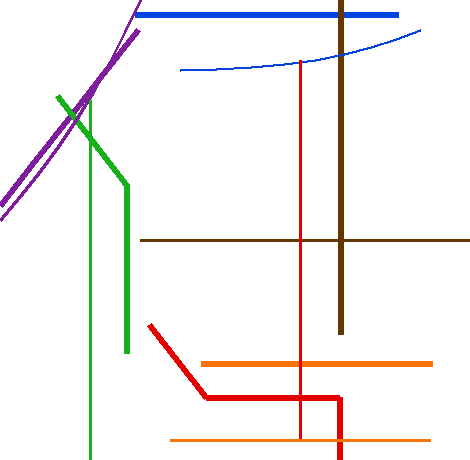

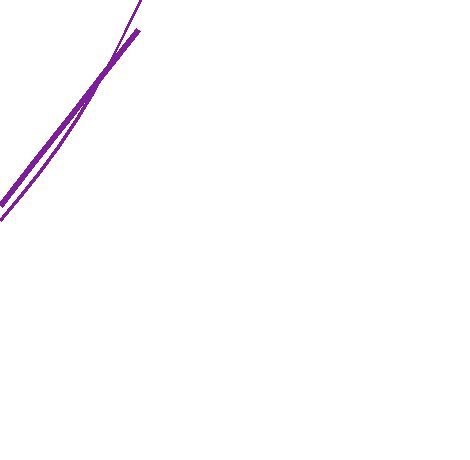

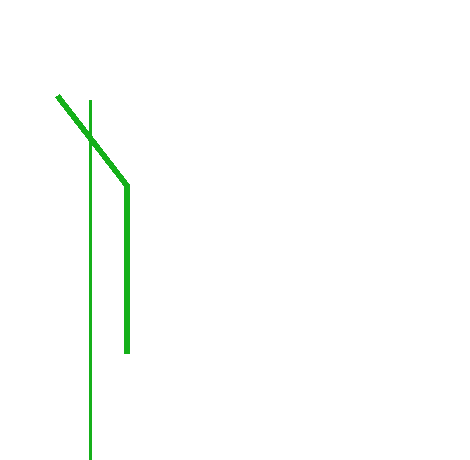

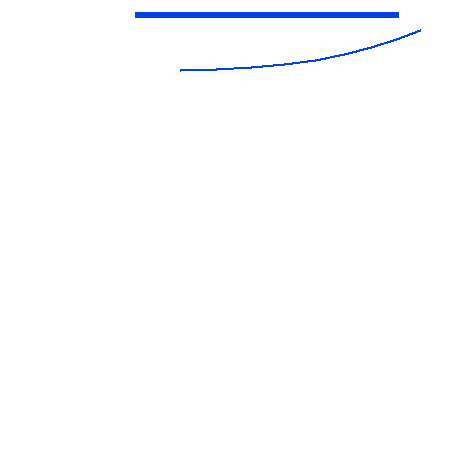

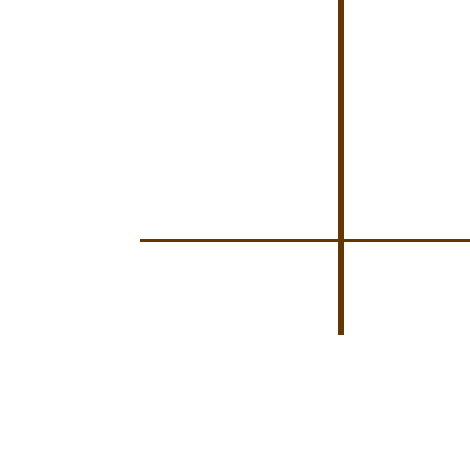

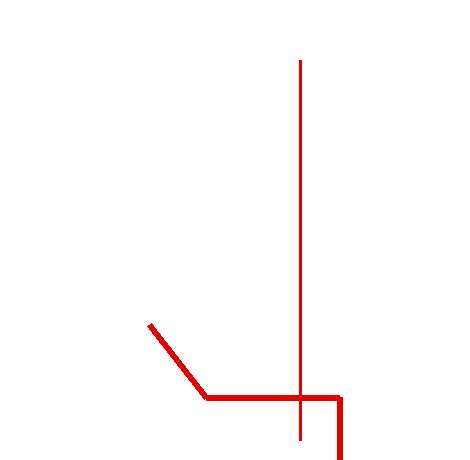

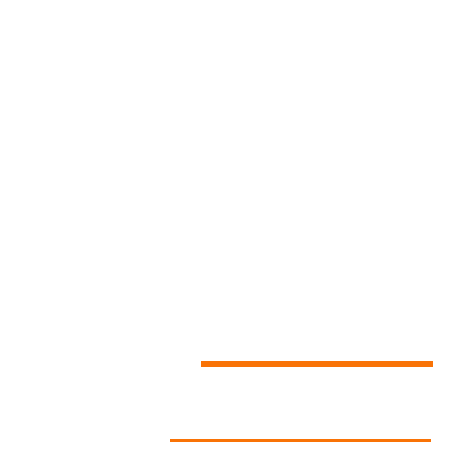

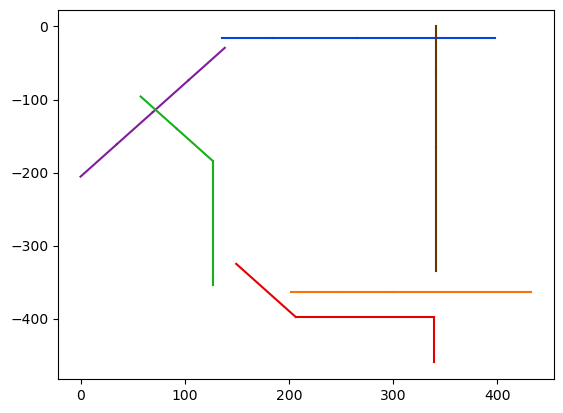

In [18]:
imgs = [Image.new(mode="RGBA", size=output_size) for _ in range(len(ref_g))]
img_full = Image.new(mode="RGBA", size=output_size)
seed(ref_l[0][0])
xcolors = ["#7e1e9c", "#15b01a", "#0343df", "#653700", "#e50000", "#f97306", "#033500", "#ffff14", "#001146"]
color_selection = [(int(c[1:3], 16), int(c[3:5], 16), int(c[5:7], 16)) for c in xcolors]
colors = color_selection[:len(ref_l)+1]
#colors = [(randint(0, 256), randint(0, 256), randint(0, 256)) for _ in range(len(ref_l)+1)]
colors_t = [(c[0], c[1], c[2], 70) for c in colors]


print(alignments)
for x in range(len(alignments)):
    i = np.where(alignments == x)[0][0]
    draw = ImageDraw.Draw(imgs[x])
    draw_full = ImageDraw.Draw(img_full)
    for a in range(len(g[i])-1):
        x1, y1 = g[i][a]
        x2, y2 = g[i][a+1]
        y1 = -(y1-output_size[1]/2)+output_size[1]/2
        y2 = -(y2-output_size[1]/2)+output_size[1]/2
        draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[x])
        draw_full.line(((x1, y1), (x2, y2)), width=6, fill=colors[x])
        plt.plot((x1, x2), (-y1, -y2), color=xcolors[x])


for i in range(len(alignments)):
    draw = ImageDraw.Draw(imgs[i])
    draw_full = ImageDraw.Draw(img_full)
    for a in range(len(ref_g[i])-1):
        x1, y1 = ref_g[i][a]
        x2, y2 = ref_g[i][a+1]
        y1 = -(y1-output_size[1]/2)+output_size[1]/2
        y2 = -(y2-output_size[1]/2)+output_size[1]/2
        draw.line(((x1, y1), (x2, y2)), width=3, fill=colors[i])
        draw_full.line(((x1, y1), (x2, y2)), width=3, fill=colors[i])

    
display(img_full)
for p in range(len(alignments)):
    display(imgs[p])


In [7]:
imgs = [Image.new(mode="RGBA", size=output_size) for _ in range(len(ref_g))]
seed(ref_l[0][0])
xcolors = ["#7e1e9c", "#15b01a", "#0343df", "#653700", "#e50000", "#f97306", "#033500", "#ffff14", "#001146"]
color_selection = [(int(c[1:3], 16), int(c[3:5], 16), int(c[5:7], 16)) for c in xcolors]
colors = color_selection[:len(ref_l)+1]
#colors = [(randint(0, 256), randint(0, 256), randint(0, 256)) for _ in range(len(ref_l)+1)]
colors_t = [(c[0], c[1], c[2], 70) for c in colors]

def drawStrokeMatches(strokes, ref, alignments, exhaust_alignment, colors, output_size, figname="han_comparison.png"):
    fig, ax = plt.subplots(ncols=5)
    for a in ax:
        a.axis([-10, output_size[0], -output_size[1], 10])
        a.axis("off")
        a.set_aspect('equal', adjustable='box')
    for x in range(len(alignments)):
        i = np.where(alignments == x)[0][0]
        for a in range(len(strokes[i])-1):
            x1, y1 = strokes[i][a]
            x2, y2 = strokes[i][a+1]
            y1 = -(y1-output_size[1]/2)+output_size[1]/2
            y2 = -(y2-output_size[1]/2)+output_size[1]/2
            ax[0].plot((x1, x2), (-y1, -y2), color=xcolors[x], linewidth=3)
            ax[3].plot((x1, x2), (-y1, -y2), color=xcolors[x], linewidth=3)
            
    for x in range(len(exhaust_alignment)):
        i = np.where(exhaust_alignment == x)[0][0]
        for a in range(len(strokes[i])-1):
            x1, y1 = strokes[i][a]
            x2, y2 = strokes[i][a+1]
            y1 = -(y1-output_size[1]/2)+output_size[1]/2
            y2 = -(y2-output_size[1]/2)+output_size[1]/2
            ax[1].plot((x1, x2), (-y1, -y2), color=xcolors[x], linewidth=3)
            ax[4].plot((x1, x2), (-y1, -y2), color=xcolors[x], linewidth=3)
    
    for i in range(len(alignments)):
        for a in range(len(ref[i])-1):
            x1, y1 = ref[i][a]
            x2, y2 = ref[i][a+1]
            y1 = -(y1-output_size[1]/2)+output_size[1]/2
            y2 = -(y2-output_size[1]/2)+output_size[1]/2
            ax[2].plot((x1, x2), (-y1, -y2), color=xcolors[i], linewidth=3)
            ax[3].plot((x1, x2), (-y1, -y2), color=xcolors[i], linewidth=3, linestyle=":")
            ax[4].plot((x1, x2), (-y1, -y2), color=xcolors[i], linewidth=3, linestyle=":")
    fig.savefig(figname)


In [8]:
exhaust_alignment = np.array(exhaustScoreAlignment(ref_char, han_char, f_read[0], data_dir))-1
print(f"heuristic: {alignments}, exhaust_alignment: {exhaust_alignment}") #[0, 3, 5, 4, 1, 2]
drawStrokeMatches(g, ref_g, alignments, np.array(exhaust_alignment), xcolors, output_size)
print(f_read, ref_char, han_char)

FileNotFoundError: [Errno 2] No such file or directory: '4EFB.2.90.gene/4EFB'